# Prepare dataset for modeling

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import math
import random
from datetime import datetime
import pandas as pd
import seaborn as sns
from collections import Counter
import gc

import xarray as xr
import glob
import rioxarray

from scipy import ndimage
from scipy.ndimage import label, binary_fill_holes, binary_erosion, generate_binary_structure
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score

# 1. Parameters

In [3]:
# Directory containing .zarr files
DATA_DIR = "/home/ubuntu/mucilage_pipeline/mucilage-detection/data/adr_test/target"

# Bands to use for analytics
BANDS = ["b02", "b03", "b04", "b8a", "b11", "b12", 'amei']  # Blue, Green, Red, NIR, NIR narrow, SWIR1, SWIR2

# zarr files
zarr_files = glob.glob(os.path.join(DATA_DIR, "*.zarr"))

# Select month
june_files = [
    f for f in zarr_files
    if os.path.basename(f).split("_")[2][:8][4:6] == "06" or os.path.basename(f).split("_")[2][:8][4:6] == "07"
  ] # or os.path.basename(f).split("_")[2][:8][4:6] == "07"

np.random.seed(42)

# 2. Helper functions

In [4]:
def resample_to_10m(ds, band, ref, folder):
    """
    Resample band to match the resolution & grid of reference band.
    ds: opened .zarr datatree
    band: name of band to resample (string)
    ref: name of reference band (string)
    """
    crs_code = "EPSG:32632"

    # Define reference band
    ref_band = ds[f"measurements/reflectance/r10m/{ref}"]  # reference (10m red)
    ref_band = ref_band.rio.write_crs(crs_code, inplace=True)

    # Band to convert
    if folder == 'measurements':
        band_20m = ds[f"measurements/reflectance/r20m/{band}"]
    else:
        band_20m = ds[f"conditions/mask/l2a_classification/r20m/{band}"] # for classification band
    band_10m = band_20m.rio.write_crs(crs_code, inplace=True)  # ensure CRS

    return band_10m.rio.reproject_match(ref_band)

def compute_amei(ds, eps=1e-6):
    red   = ds["measurements/reflectance/r10m/b04"] / 10000.0
    green = ds["measurements/reflectance/r10m/b03"] / 10000.0
    nir   = resample_to_10m(ds, 'b8a', 'b04', folder='measurements') / 10000.0
    swir  = resample_to_10m(ds, 'b11', 'b04', folder='measurements') / 10000.0

    # AMEI = (2*red + nir - 2*swir) / (green + 0.25*swir)
    denom = green + 0.25 * swir
    amei  = (2*red + nir - 2*swir) / (denom + eps)

    return amei.rename("amei")  # keep DataArray with name


def compute_ndwi(ds, eps=1e-6):
    green = ds["measurements/reflectance/r10m/b03"] / 10000.0
    nir   = resample_to_10m(ds, 'b8a', 'b04', folder='measurements') / 10000.0

    # NDWI = (green - nir) / (green + nir)
    ndwi = (green - nir) / (green + nir + eps)

    return ndwi.rename("ndwi")  # keep DataArray with name


def clean_water_mask(water_mask):
    """
    Fix water mask by:
    1. Keeping only the sea (remove lakes/rivers).
    2. Filling cloud holes in the sea.
    """
    H, W = water_mask.shape
    
    # Keep only the largest connected component that touches border (most prob the sea)
    st = generate_binary_structure(2, 2)   # 8-connectivity
    lab, nlab = label(water_mask, structure=st) # different label for each connected water body
    
    if nlab == 0:
        return np.zeros_like(water_mask, dtype=bool)

    # Find component sizes
    sizes = np.bincount(lab.ravel())
    sizes[0] = 0  # background, we don't consider it

    # Keep the largest component
    largest_label = sizes.argmax()
    sea_only = (lab == largest_label)

    # Fill holes inside sea (caused by clouds)
    sea_filled = binary_fill_holes(sea_only)

    return sea_filled.astype(bool)

def build_stack_10m(ds, bands):
    """
    Create (H, W, C) stack from selected bands/indices.
    """
    stack = []
    ref_10m = ds["measurements/reflectance/r10m/b04"]  # reference (10m red)
    
    for b in bands:
        if b in ds['measurements/reflectance/r10m']:   # reflectance at 10m
            arr = ds['measurements/reflectance/r10m'][b].values.astype(np.float32) / 10000
        elif b in ds['measurements/reflectance/r20m']: # reflectance at 20m
            arr = resample_to_10m(ds, b, 'b04', folder='measurements')
            arr = arr.values.astype(np.float32) / 10000
        elif b == "amei":
            arr = compute_amei(ds)
        elif b == "ndwi":
            arr = compute_ndwi(ds)
        else:
            raise ValueError(f"Band {b} not found or not supported.")
        
        stack.append(arr)
    stack = np.stack(stack, axis=-1)  # (H, W, C)
    return stack

def build_stack_10m_lazy(ds, bands):
    """
    Return a lazy dask-backed stack (H, W, C) instead of full NumPy.
    """
    stack = []

    for b in bands:
        if b in ds['measurements/reflectance/r10m']:
            arr = ds['measurements/reflectance/r10m'][b] / 10000.0
        elif b in ds['measurements/reflectance/r20m']:
            arr = resample_to_10m(ds, b, 'b04', folder='measurements') / 10000.0
        elif b == "amei":
            arr = compute_amei(ds)
        elif b == "ndwi":
            arr = compute_ndwi(ds)
        else:
            raise ValueError(f"Band {b} not found or not supported.")

        # Expand dims and assign band coordinate for all arrays
        arr = arr.expand_dims(band=[b])
        stack.append(arr)

    # Concatenate along band dimension lazily
    stack = xr.concat(stack, dim="band").transpose("y", "x", "band")
    return stack

# 3. Patchify

## Prepare 256x256xbands patches from each image. Patches are created all over the image (1764 patches for each image)

In [5]:
def extract_patches_3d(array, patch_size=256, stride=256):
    """
    Extract patches from (H, W, C) array.
    Returns a list of patches with shape (patch_size, patch_size, C).
    """
    H, W, C = array.shape
    patches = []

    for i in range(0, H - patch_size + 1, stride):
        for j in range(0, W - patch_size + 1, stride):
            patch = array[i:i+patch_size, j:j+patch_size, :]
            patches.append(patch)
    return patches


def process_folder(zarr_files, bands, patch_size=256, stride=256):
    """
    Loop through all zarr files in a folder and extract patches.
    """
    all_patches = []

    for zf in zarr_files:
        print(f"Processing {zf} ...")
        ds = xr.open_datatree(zf, engine="zarr", mask_and_scale=False)

        stack = build_stack_10m(ds, bands)
        patches = extract_patches_3d(stack, patch_size, stride)
        
        all_patches.extend(patches)
        del (ds, stack, patches)
    
    return all_patches

In [6]:
patches = process_folder(zarr_files, BANDS)

print(f"Total patches: {len(patches)}")
print(f"Patch shape: {patches[0].shape}")

Processing /home/ubuntu/mucilage_pipeline/mucilage-detection/data/adr_test/target/S2A_MSIL2A_20240825T100551_N0511_R022_T32TQQ_20240825T162201.zarr ...
Processing /home/ubuntu/mucilage_pipeline/mucilage-detection/data/adr_test/target/S2B_MSIL2A_20240807T095549_N0511_R122_T32TQQ_20240807T132638.zarr ...
Processing /home/ubuntu/mucilage_pipeline/mucilage-detection/data/adr_test/target/S2B_MSIL2A_20240728T095549_N0511_R122_T32TQQ_20240728T114034.zarr ...


: 

In [2]:
# Load .npz file
patches_train = np.load('/home/ubuntu/mucilage_pipeline/mucilage-detection/saved_npy/train_cache.npz')['X']
patches_val = np.load('/home/ubuntu/mucilage_pipeline/mucilage-detection/saved_npy/val_cache.npz')['X']
patches_test = np.load('/home/ubuntu/mucilage_pipeline/mucilage-detection/saved_npy/test_cache.npz')['X']

# concatenate all patches
all_patches = np.concatenate([patches_train, patches_val, patches_test], axis=0)
print(f"All patches shape: {all_patches.shape}")


All patches shape: (1368, 256, 256, 11)


## Strategic patchify. Generate patches along the water border.

In [4]:
def sample_patch_centers(water_mask, n_patches, patch_size=256, border_weight=0.6):
    """
    Randomly sample patch centers with more focus on water-land borders.
    """
    H, W = water_mask.shape
    
    # Create a mask from the shoreline (water/land border) expanding seawards
    border_mask = water_mask & ~binary_erosion(water_mask, iterations=300) # choose pixels number
    
    # Probability map
    probs = np.zeros_like(water_mask, dtype=np.float32)
    probs[border_mask] = border_weight   # 70% on border
    probs[water_mask]  = 1.0 - border_weight  # 30% on water
    
    probs = probs / probs.sum()  # normalize to 1
    
    # Flatten and sample indices
    flat_idx = np.random.choice(H*W, size=n_patches, replace=False, p=probs.ravel()) # randomly picks pixel indices based on the prob map (p)
    centers = np.column_stack(np.unravel_index(flat_idx, (H, W))) # convert indices back into (row, col) coordinates in the 2D image
    
    # Convert to (row, col) top-left corners
    half = patch_size // 2 # centering
    corners = [(max(0, r-half), max(0, c-half)) for r, c in centers]
    del probs
    
    return corners


def extract_patches_focus(stack, water_mask, n_patches=150, patch_size=256):
    """
    Extract (256,256,C) patches with sampling biased toward border regions.
    """
    H, W, C = stack.shape
    corners = sample_patch_centers(water_mask, n_patches, patch_size)
    
    patches = []
    for i, j in corners:
        if i+patch_size <= H and j+patch_size <= W:
            # This loads only the patch into memory (not the whole image)
            patch = stack.isel(
                y=slice(i, i+patch_size),
                x=slice(j, j+patch_size)
            ).to_numpy()
            patches.append(patch)
    del corners

    return patches


def process_folder_opt(zarr_files, bands, water_mask):
    """
    Loop through all zarr files in a folder and extract patches.
    """
    all_patches = []

    for zf in zarr_files:
        print(f"Processing {zf} ...")
        ds = xr.open_datatree(zf, engine="zarr", mask_and_scale=False, chunks={})

        stack = build_stack_10m_lazy(ds, bands)
        patches = extract_patches_focus(stack, water_mask)
        
        all_patches.extend(patches)
        del ds, stack, patches # to avoid RAM overload
        gc.collect()
    
    return all_patches


def plot_patch_grid(patches, n=10, rgb_idx=(2,1,0)):
    """
    Show n x n grid of RGB patches.
    - patches: list of (256,256,C) arrays
    - n: grid size
    - rgb_idx: indices of stack channels to use as RGB (default assumes [b2,b3,b4,...])
    """
    fig, axes = plt.subplots(n, n, figsize=(15, 15))
    fig.subplots_adjust(hspace=0.05, wspace=0.05)

    # pick random patches
    chosen = random.sample(patches, n*n) if len(patches) > n*n else patches[:n*n]

    for ax, patch in zip(axes.flat, chosen):
        # select RGB channels
        rgb = patch[..., list(rgb_idx)]
        rgb = rgb.astype(np.float32)

        # simple normalization (per patch)
        p2, p98 = np.nanpercentile(rgb, (2, 98))
        rgb = np.clip((rgb - p2) / (p98 - p2 + 1e-6), 0, 1)

        ax.imshow(rgb)
        ax.axis("off")

    plt.show()
    plt.close("all")

In [5]:
# Generate water mask
# NOTE: here the water mask is generated from the first file and kept for all the others

dt = xr.open_datatree(june_files[2], engine="zarr", mask_and_scale=False) # better to take the water mask from a cloud free day (clouds are considered as nonwater)
scl = resample_to_10m(dt, 'scl', 'b04', folder='conditions') # 10m resolution
scl = scl.squeeze().values
raw_water_mask = (scl == 6)
water_mask = clean_water_mask(raw_water_mask) # remove inland lakes and fill clouds over sea

patches = process_folder_opt(june_files, BANDS, water_mask)

Processing /home/ubuntu/mucilage_pipeline/mucilage-detection/data/adr_test_tqr/target/S2B_MSIL2A_20240731T100559_N0511_R022_T32TQR_20240731T125141.zarr ...
Processing /home/ubuntu/mucilage_pipeline/mucilage-detection/data/adr_test_tqr/target/S2B_MSIL2A_20240728T095549_N0511_R122_T32TQR_20240728T114034.zarr ...
Processing /home/ubuntu/mucilage_pipeline/mucilage-detection/data/adr_test_tqr/target/S2B_MSIL2A_20240721T100559_N0510_R022_T32TQR_20240721T125344.zarr ...
Processing /home/ubuntu/mucilage_pipeline/mucilage-detection/data/adr_test_tqr/target/S2A_MSIL2A_20240713T100031_N0510_R122_T32TQR_20240713T135550.zarr ...
Processing /home/ubuntu/mucilage_pipeline/mucilage-detection/data/adr_test_tqr/target/S2B_MSIL2A_20240708T095549_N0510_R122_T32TQR_20240708T124046.zarr ...
Processing /home/ubuntu/mucilage_pipeline/mucilage-detection/data/adr_test_tqr/target/S2A_MSIL2A_20240726T100601_N0511_R022_T32TQR_20240726T193850.zarr ...
Processing /home/ubuntu/mucilage_pipeline/mucilage-detection/dat

In [6]:
# Save variable to disk to avoid recomputing

patches_array = np.array(patches, dtype=np.float32)  # shape (N, 256, 256, C)
np.save("/home/ubuntu/mucilage_pipeline/patches_tqr.npy", patches_array)

In [9]:
patches_array = np.load('/home/ubuntu/mucilage_pipeline/mucilage-detection/saved_npy/train_cache.npz')['X']

### Visualize border mask

In [5]:
dt = xr.open_datatree('/home/ubuntu/mucilage_pipeline/DeltaTwin-od-flood/models/data/target/S2B_MSIL2A_20250318T100639_N0511_R022_T32TPP_20250318T141314.zarr', engine="zarr", mask_and_scale=False)
scl = resample_to_10m(dt, 'scl', 'b04', folder='conditions') # 10m resolution
scl = scl.squeeze().values
raw_water_mask = (scl == 6)
raw_border_mask = raw_water_mask & ~binary_erosion(raw_water_mask, iterations=300)
water_mask = clean_water_mask(raw_water_mask)
border_mask = water_mask & ~binary_erosion(water_mask, iterations=300)

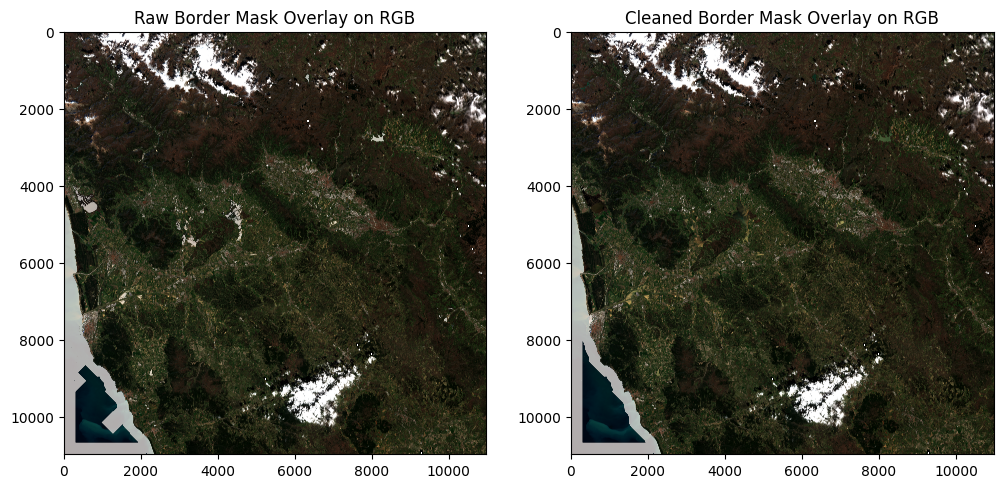

: 

In [ ]:
# Define RGB background
#dt = xr.open_datatree(june_files[2], engine="zarr", mask_and_scale=False)
rgb = np.dstack([
    dt['measurements/reflectance/r10m/b04'].values.astype(np.float32) / 10000.0,
    dt['measurements/reflectance/r10m/b03'].values.astype(np.float32) / 10000.0,
    dt['measurements/reflectance/r10m/b02'].values.astype(np.float32) / 10000.0
])
p2, p98 = np.nanpercentile(rgb, (2, 98))
rgb = np.clip((rgb - p2) / (p98 - p2), 0, 1)

# Plot border masks
fig, axes = plt.subplots(1,2, figsize=(12,6))
axes[0].imshow(rgb)
axes[0].imshow(np.where(raw_border_mask, 1, np.nan), cmap="Reds", alpha=0.7)
axes[0].set_title("Raw Border Mask Overlay on RGB")
axes[1].imshow(rgb)
axes[1].imshow(np.where(border_mask, 1, np.nan), cmap="Reds", alpha=0.7)
axes[1].set_title("Cleaned Border Mask Overlay on RGB")
plt.show()

plt.close("all")
del rgb

### Visualize patches

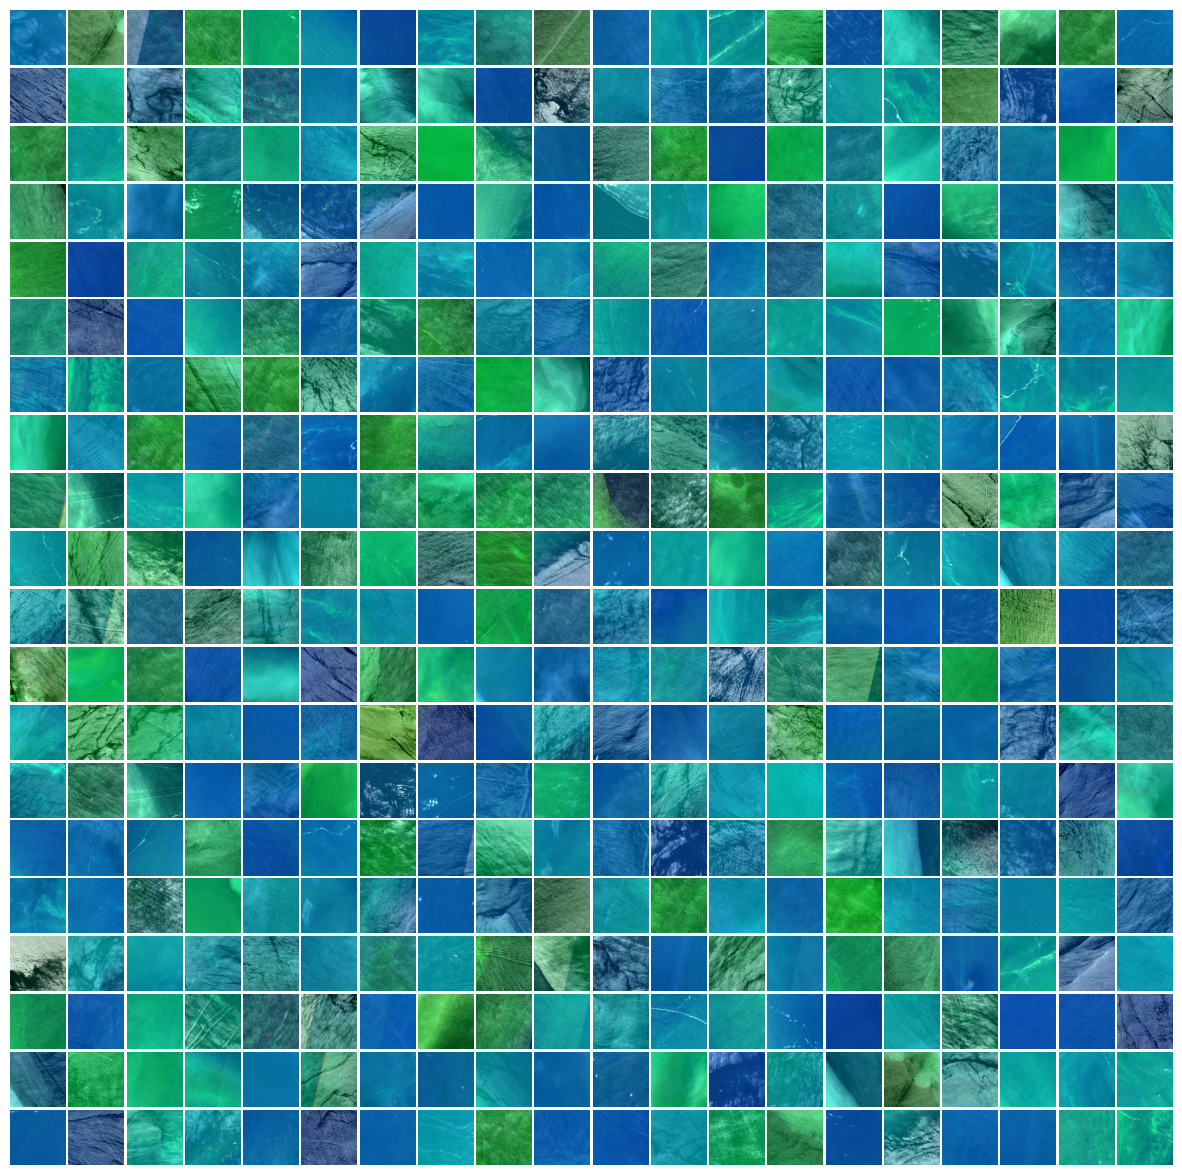

In [11]:
plot_patch_grid(list(patches_array), n=20, rgb_idx=(3,2,1))

### Analyses on patches

In [ ]:
# Faulty patches (contain infite values)
patches_array = np.array(patches)  # shape (n, 256, 256, 8)

# Check each patch
bad_patches = []
for i, p in enumerate(patches_array):
    if np.isnan(p).any() or np.isinf(p).any():
        bad_patches.append(i)

print(f"Number of bad patches: {len(bad_patches)}")
print("Indices of bad patches:", bad_patches)

patches_filt = np.delete(patches_array, bad_patches, axis=0)

Number of bad patches: 0
Indices of bad patches: []


In [13]:
def patch_features(patch):
    # patch: (256, 256, 8) with bands [B2, B3, B4, B8, B11, B12, AMEI, NDWI]

    # Exclude redundant patches (from correlation matrix, B3 and B11)
    keep_idx = [0, 2, 3, 5, 6, 7]
    patch_sel = patch[:, :, keep_idx]

    feats = []
    
    # per-channel mean and std
    feats.extend(patch.mean(axis=(0,1)))  # 8 features
    feats.extend(patch.std(axis=(0,1)))   # 8 features
    
    return np.array(feats)

# Build feature matrix
# X = np.array([patch_features(p) for p in patches_filt])  # shape: (N_patches, 16) -- old method with mean and std
X = all_patches.reshape(all_patches.shape[0], -1) 
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

Kmeans

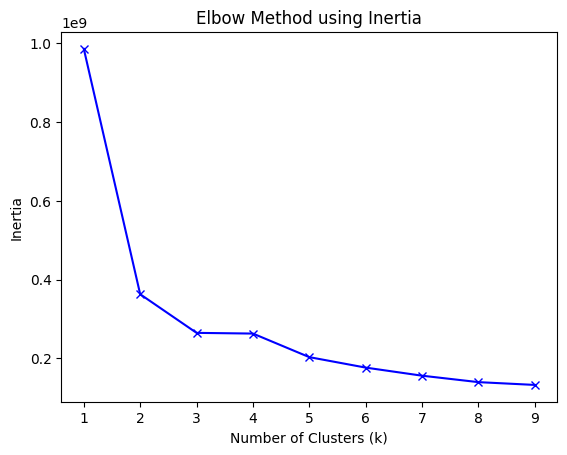

In [15]:
# Elbow method using inertia

inertias = []
K = range(1, 10)

for k in K:
    kmeans = KMeans(n_clusters=k, random_state=42).fit(X_scaled)    
    inertias.append(kmeans.inertia_)
plt.plot(K, inertias, 'bx-')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia')
plt.title('Elbow Method using Inertia')
plt.show()

In [16]:
# Kmeans
kmeans = KMeans(n_clusters=2, random_state=42)
labels = kmeans.fit_predict(X_scaled)

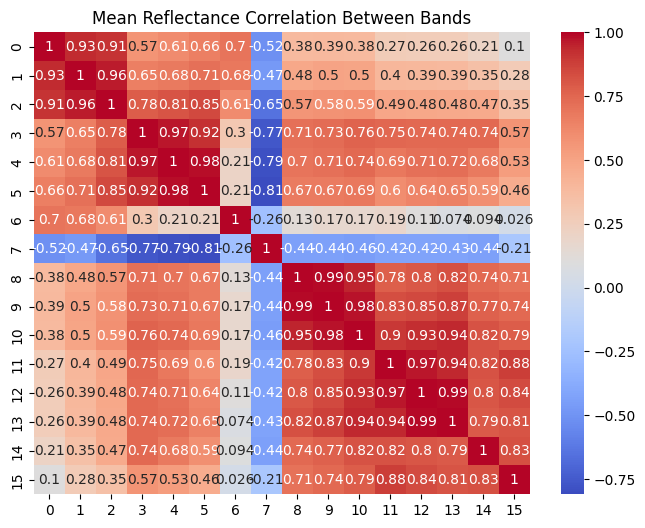

In [36]:
corr =  pd.DataFrame(X).corr()
plt.figure(figsize=(8,6))
sns.heatmap(corr, annot=True, cmap="coolwarm")
plt.title("Mean Reflectance Correlation Between Bands")
plt.show()

/tmp/ipykernel_1168002/3149796107.py:6: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(X_pca[idx, 0], X_pca[idx, 1], s=10, label=f"Cluster {lbl}", cmap="tab10")


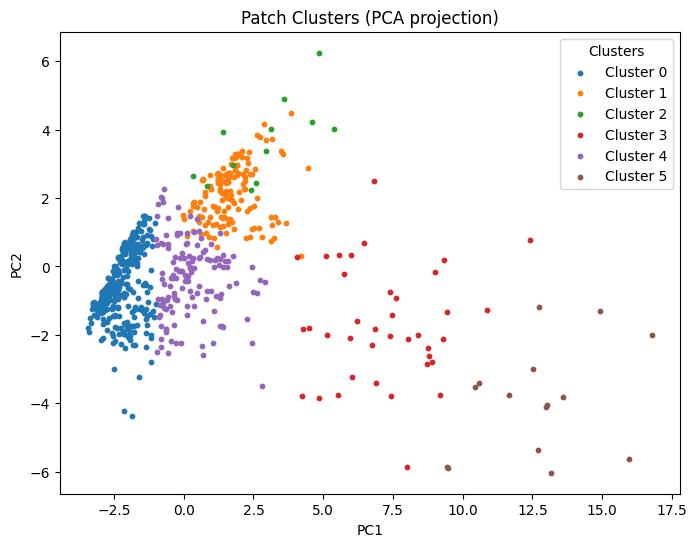

In [44]:
X_pca = PCA(n_components=2).fit_transform(X_scaled)

plt.figure(figsize=(8,6))
for lbl in np.unique(labels):
    idx = labels == lbl
    plt.scatter(X_pca[idx, 0], X_pca[idx, 1], s=10, label=f"Cluster {lbl}", cmap="tab10")

plt.title("Patch Clusters (PCA projection)")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.legend(title="Clusters")  # Add legend
plt.show()

In [33]:
# Remove the outlie in the plot

outlier_idx = np.where(X_pca[:, 1] < -10)[0]  # PC1 is column 0
print("Outlier indices:", outlier_idx)

# Remove them from everything
X_clean = np.delete(X_scaled, outlier_idx, axis=0)
X_pca_clean = np.delete(X_pca, outlier_idx, axis=0)
labels_clean = np.delete(labels, outlier_idx, axis=0)  # if you already clustered
patches_clean = [p for i, p in enumerate(patches) if i not in outlier_idx]

Outlier indices: [591]


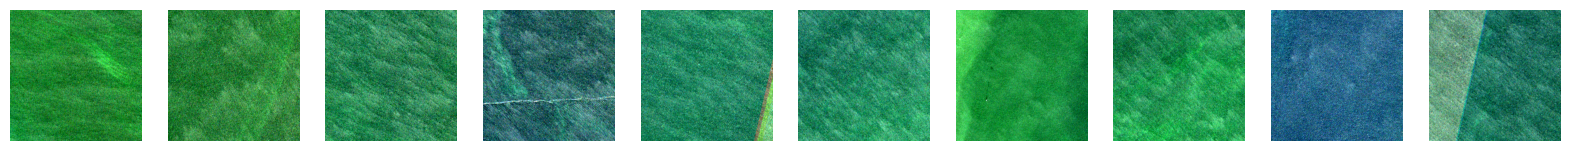

In [28]:
def show_cluster_examples(patches, labels, cluster_id, n=10):
    idxs = np.where(labels==cluster_id)[0][80:90]
    fig, axes = plt.subplots(1,n, figsize=(20,3))
    for ax,i in zip(axes, idxs):
        # show true-color RGB (B4,B3,B2 → indices 2,1,0)
        rgb = patches[i][:,:, [3,2,1]]
        p2, p98 = np.nanpercentile(rgb, (2, 98))
        rgb = np.clip((rgb - p2) / (p98 - p2 + 1e-6), 0, 1)
        ax.imshow(rgb)
        ax.axis("off")
    plt.show()
    plt.close('all')

def show_all_clusters(patches, labels, cluster_id, n=None, ncols=10):
    # Get indices of all patches in the cluster
    idxs = np.where(labels == cluster_id)[0]

    # If n is set, limit to n patches
    if n is not None:
        idxs = idxs[:n]

    n_patches = len(idxs)
    nrows = math.ceil(n_patches / ncols)

    fig, axes = plt.subplots(nrows, ncols, figsize=(2*ncols, 2*nrows))
    axes = np.array(axes).reshape(-1)  # flatten in case it's 2D

    for ax, i in zip(axes, idxs):
        # show true-color RGB (B4,B3,B2 → indices 2,1,0)
        rgb = patches[i][:,:, [2,1,0]]
        p2, p98 = np.nanpercentile(rgb, (2, 98))
        rgb = np.clip((rgb - p2) / (p98 - p2 + 1e-6), 0, 1)
        ax.imshow(rgb)
        ax.axis("off")

    # Hide any extra axes if n_patches < nrows*ncols
    for ax in axes[n_patches:]:
        ax.axis("off")

    plt.suptitle(f"Cluster {cluster_id} examples", fontsize=16)
    plt.tight_layout()
    plt.show()
    plt.close('all')

show_cluster_examples(all_patches, labels, cluster_id=0, n=10)

# CLuster 0 mix of algae with clouds, deep water and deep water with mucilage
# Cluster 1 algae with clouds (?)
# Cluster 2 mucilage next to coast
# Cluster 3 algae blooms
# Cluster 4 deep water and filaments of mucilage
# Cluster 5 low clouds

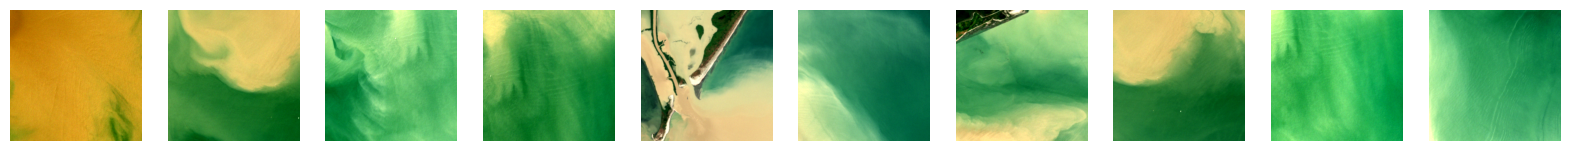

In [14]:
def show_cluster_examples(patches, labels, cluster_id, n=10):
    idxs = np.where(labels==cluster_id)[0][:n]
    fig, axes = plt.subplots(1,n, figsize=(20,3))
    for ax,i in zip(axes, idxs):
        # show true-color RGB (B4,B3,B2 → indices 2,1,0)
        rgb = patches[i][:,:, [2,1,0]]
        p2, p98 = np.nanpercentile(rgb, (2, 98))
        rgb = np.clip((rgb - p2) / (p98 - p2 + 1e-6), 0, 1)
        ax.imshow(rgb)
        ax.axis("off")
    plt.show()
    plt.close('all')

show_cluster_examples(patches, labels, cluster_id=3)

In [46]:
# Check for balance

counts = Counter(labels)
print(counts)

Counter({np.int32(0): 351, np.int32(1): 151, np.int32(4): 136, np.int32(3): 38, np.int32(5): 15, np.int32(2): 12})


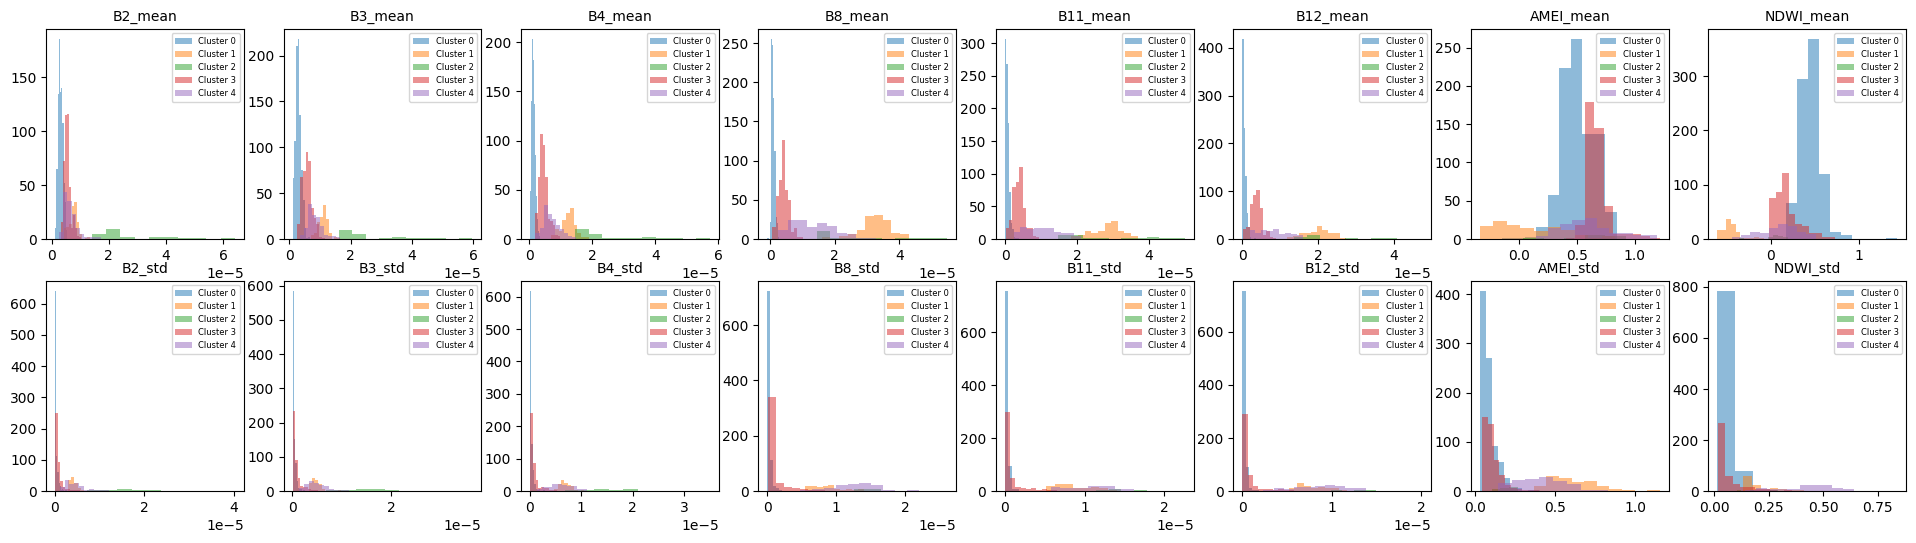

In [23]:
feature_names = ["B2_mean","B3_mean", "B4_mean", "B8_mean","B11_mean", "B12_mean", "AMEI_mean", "NDWI_mean", 
                 "B2_std","B3_std", "B4_std", "B8_std","B11_std", "B12_std", "AMEI_std", "NDWI_std"]

fig, axes = plt.subplots(2, 8, figsize=(24, 6))
axes = axes.ravel()
for i, fname in enumerate(feature_names):
    ax = axes[i]
    for cluster_id in np.unique(labels):
        ax.hist(X[labels == cluster_id, i], bins=10, alpha=0.5, label=f'Cluster {cluster_id}')
    ax.set_title(fname, fontsize=10)
    ax.legend(fontsize=6)
plt.show()

# Top-left coordinates

In [9]:
def resample_to_10m(ds, band, ref, folder):
    """
    Resample band to match the resolution & grid of reference band.
    ds: opened .zarr datatree
    band: name of band to resample (string)
    ref: name of reference band (string)
    """
    crs_code = "EPSG:32632"

    # Define reference band
    ref_band = ds[f"measurements/reflectance/r10m/{ref}"]  # reference (10m red)
    ref_band = ref_band.rio.write_crs(crs_code, inplace=True)

    # Band to convert
    if folder == 'measurements':
        band_20m = ds[f"measurements/reflectance/r20m/{band}"]
    else:
        band_20m = ds[f"conditions/mask/l2a_classification/r20m/{band}"] # for classification band
    band_10m = band_20m.rio.write_crs(crs_code, inplace=True)  # ensure CRS

    return band_10m.rio.reproject_match(ref_band)

def compute_amei(ds, eps=1e-6):
    red   = ds["measurements/reflectance/r10m/b04"] / 10000.0
    green = ds["measurements/reflectance/r10m/b03"] / 10000.0
    nir   = resample_to_10m(ds, 'b8a', 'b04', folder='measurements') / 10000.0
    swir  = resample_to_10m(ds, 'b11', 'b04', folder='measurements') / 10000.0

    # AMEI = (2*red + nir - 2*swir) / (green + 0.25*swir)
    denom = green + 0.25 * swir
    amei  = (2*red + nir - 2*swir) / (denom + eps)

    return amei.rename("amei")  # keep DataArray with name



def clean_water_mask(ds):
    """
    Fix water mask by:
    1. Keeping only the sea (remove lakes/rivers).
    2. Filling cloud holes in the sea.
    """

    scl = resample_to_10m(ds, 'scl', 'b04', folder='conditions')
    scl = scl.squeeze().values
    raw_water_mask = (scl == 6)
    H, W = raw_water_mask.shape

    # Keep only the largest connected component that touches border (most prob the sea)
    st = generate_binary_structure(2, 2)   # 8-connectivity
    lab, nlab = label(raw_water_mask, structure=st) # different label for each connected water body
    
    if nlab == 0:
        return np.zeros_like(raw_water_mask, dtype=bool)

    # Find component sizes
    sizes = np.bincount(lab.ravel())
    sizes[0] = 0  # background, we don't consider it

    # Keep the largest component
    largest_label = sizes.argmax()
    sea_only = (lab == largest_label)

    # Fill holes inside sea (caused by clouds)
    sea_filled = binary_fill_holes(sea_only)

    return sea_filled.astype(bool)


def build_stack_10m(ds, bands):
    """
    Return a lazy dask-backed stack (H, W, C) instead of full NumPy.
    """
    stack = []

    for b in bands:
        if b in ds['measurements/reflectance/r10m']:
            arr = ds['measurements/reflectance/r10m'][b] / 10000.0
        elif b in ds['measurements/reflectance/r20m']:
            arr = resample_to_10m(ds, b, 'b04', folder='measurements') / 10000.0
        elif b == "amei":
            arr = compute_amei(ds)
        else:
            raise ValueError(f"Band {b} not found or not supported.")

        # Expand dims and assign band coordinate for all arrays
        arr = arr.expand_dims(band=[b])
        stack.append(arr)

    # Concatenate along band dimension lazily
    stack = xr.concat(stack, dim="band").transpose("y", "x", "band")
    return stack


def sample_patch_corners(water_mask, n_patches, patch_size=256, border_weight=0.6):
    """Sample patch *corners* (top-left) biased toward shoreline."""
    H, W = water_mask.shape
    border_mask = water_mask & ~binary_erosion(water_mask, iterations=300)

    probs = np.zeros_like(water_mask, dtype=np.float32)
    probs[border_mask] = border_weight
    probs[water_mask]  = 1.0 - border_weight
    probs = probs / probs.sum()

    flat_idx = np.random.choice(H*W, size=n_patches, replace=False, p=probs.ravel())
    centers = np.column_stack(np.unravel_index(flat_idx, (H, W)))

    # convert centers → corners (top-left coordinates)
    half = patch_size // 2
    corners = [(max(0, r-half), max(0, c-half)) for r, c in centers]
    return corners


def create_patches_dataframe(zarr_files, bands, n_patches_per_file=150, patch_size=256):
    """
    For each zarr file, extract top-left coordinates of sampled patches,
    and store them along with zarr path in a DataFrame.
    
    Returns:
        df_patches: DataFrame with columns ['zarr_path', 'x', 'y']
    """
    records = []

    for zf in zarr_files:
        print(f"Processing {zf} for patch coordinates...")
        ds = xr.open_datatree(zf, engine="zarr", mask_and_scale=False, chunks={})

        # Compute water mask
        water_mask = clean_water_mask(ds)
        
        # Retrieve shape bands
        band = ds['measurements/reflectance/r10m/b04']
        H, W = band.shape
        corners = sample_patch_corners(water_mask, n_patches=n_patches_per_file, patch_size=patch_size)
        
        for y, x in corners:
            # Ensure the patch fits within the image
            if y + patch_size <= H and x + patch_size <= W:
                records.append({'zarr_path': zf, 'x': x, 'y': y})
        
        # Free memory
        del ds
        gc.collect()
    
    df_patches = pd.DataFrame(records)
    print(f"Total patches collected: {len(df_patches)}")

    return df_patches

In [ ]:
import pandas as pd

# new patches with coordinates
df = pd.read_csv("/home/ubuntu/mucilage_pipeline/mucilage-detection/csv/patches_test_42.csv")

# old labels tracked by index
df_labels = pd.read_csv("/home/ubuntu/mucilage_pipeline/mucilage-detection/csv/labels_corrected.csv")  # has index, label

# merge safely
df_merged = df.merge(df_labels, on="index", how="inner")

df_merged.to_csv("/home/ubuntu/mucilage_pipeline/mucilage-detection/csv/patches_with_labels.csv", index=False)
print("✅ Saved merged labels with coordinates to patches_with_labels.csv")

Old patch:


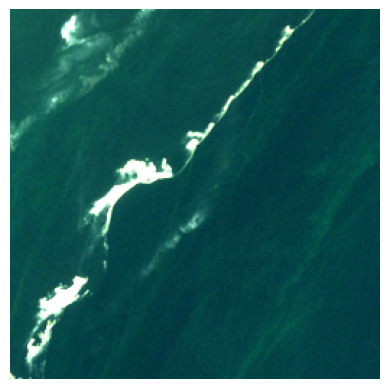

New patch:


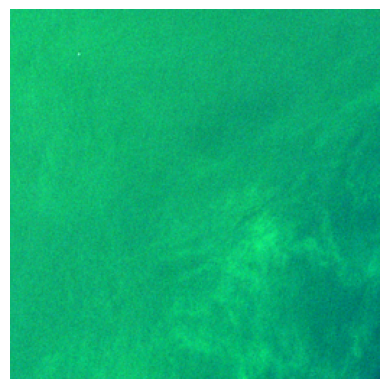

In [5]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt

# --- Load old patches ---
old_patches = np.load("/home/ubuntu/mucilage_pipeline/patches.npy")  # shape (N, 256, 256, 7)

# --- Load new CSV with coordinates ---
first_patch_row = df.iloc[0]
zarr_path = first_patch_row["zarr_path"]
x, y = int(first_patch_row["x"]), int(first_patch_row["y"])

# --- Load the stack from Zarr ---
BANDS = ["b02", "b03", "b04", "b08", "b11", "b12", "amei"]  # adjust as needed

ds = xr.open_datatree(zarr_path, engine="zarr", mask_and_scale=False, chunks={})

# Suppose build_stack_10m returns (H,W,C)
stack = build_stack_10m(ds, BANDS)

# Extract patch at top-left corner
patch_new = stack.isel(y=slice(y, y+256), x=slice(x, x+256)).to_numpy()

ds.close()

# --- Convert to RGB for display ---
def show_rgb(patch, bands=["b04","b03","b02"]):
    # patch shape (H,W,C)
    rgb_idx = [BANDS.index(b) for b in bands]
    rgb = patch[..., rgb_idx]
    p2, p98 = np.nanpercentile(rgb, (2, 98))
    rgb = np.clip((rgb - p2) / (p98 - p2 + 1e-6), 0, 1)
    plt.imshow(rgb)
    plt.axis("off")
    plt.show()

# --- Display old and new ---
print("Old patch:")
show_rgb(old_patches[0])

print("New patch:")
show_rgb(patch_new)

# 4. Prepare dataset

In [2]:
# Load patches
patches = np.load("/home/ubuntu/mucilage_pipeline/patches.npy")  # shape (1643, 256, 256, 8)

# Load labels CSV
labels_df = pd.read_csv("/home/ubuntu/mucilage_pipeline/mucilage-detection/src/labels_corrected.csv")
#labels_df = labels_df[~labels_df['label'].isin(['algae'])]

# Map string labels to integers
label_mapping = {
    "clean_water": 0,
    "mucilage": 1,
    "algae": 2  # optional, need to check
}
labels_df["label_id"] = labels_df["label"].map(label_mapping)

# Subset patches based on indices in CSV
selected_indices = labels_df["index"].values
X = patches[selected_indices]   # shape (N, 256,256,8)
y = labels_df["label_id"].values  # shape (N,)

print("X shape:", X.shape)
print("y shape:", y.shape)

X shape: (911, 256, 256, 8)
y shape: (911,)


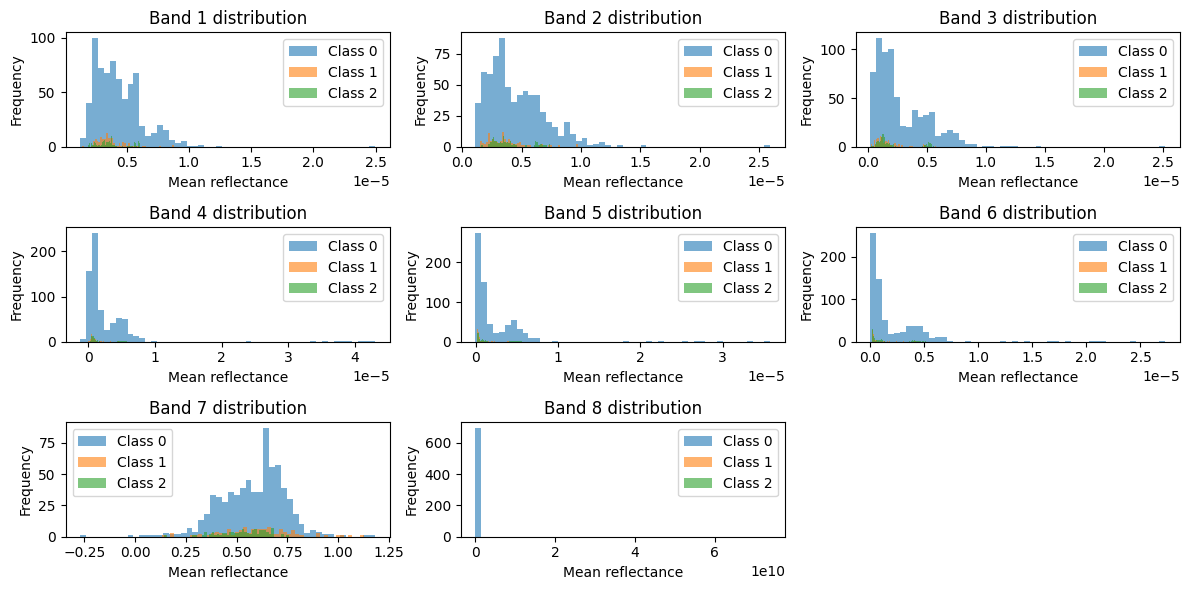

In [4]:
num_bands = X.shape[-1]
classes = np.unique(y)

# Compute mean values per patch per band
# Shape -> (n_patches, 8)
X_means = X.mean(axis=(1, 2))

plt.figure(figsize=(12, 6))

for band in range(num_bands):
    plt.subplot(3, 3, band+1)  # arrange in a grid
    for cls in classes:
        class_means = X_means[y == cls, band]
        plt.hist(class_means, bins=50, alpha=0.6, label=f"Class {cls}")
    plt.title(f"Band {band+1} distribution")
    plt.xlabel("Mean reflectance")
    plt.ylabel("Frequency")
    plt.legend()

plt.tight_layout()
plt.show()